## Imports

In [100]:
# Scott's data simulation repo
from troposim.simulated_stack import data_loader, load_all_data, plot_data, save_predictions_as_tifs
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model

In [3]:
%matplotlib inline

## Fetch Data

This is from Scott's "troposim" repo: https://github.com/scottstanie/troposim/blob/main/troposim/simulated_stack.py
Data is already pre-noised and DEMs generated.
Deformation time series and DEMs are also already normalized to unit variance and centered at 0. Yay for clean data.

### Load

In [4]:
data_dir = '/data5/autoencoder/texas_dem/'

In [5]:
# X, y = load_all_data(data_dir + "simulated_stack0*.h5", data_dir + "elevation_looked.dem", normalize=False)
X, y = load_all_data(data_dir + "simulated_stack_day1*.h5", data_dir + "elevation_looked.dem", normalize=False)

defo_stack.shape = (9, 3000, 3000)
defo_stack.shape = (9, 3000, 3000)
defo_stack.shape = (9, 3000, 3000)


### Reshape

In [6]:
print(X.shape, y.shape)
y = np.moveaxis(y, 1, -1)
X = np.expand_dims(X, -1)
print(X.shape, y.shape)

(678, 10, 48, 48) (678, 1, 48, 48)
(678, 10, 48, 48, 1) (678, 48, 48, 1)


##### Notes on dataset shape from here on out
- index 0: number of data samples. 
- index 1: number of images in the sample. For training set, it's 10 images with the first image being the DEM, and the next 9 being the timeseries. For the target sets, it's just one image. 
- index 2 & 3: pixel dimensions of the images
- index 4: number of channels. Always 1 in this notebook.

### Split into train and test

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [8]:
print(np.max(np.abs(y_train)))
print(np.max(np.abs(y_test)))

4.9743414
4.776641


### Normalize

In [9]:
class MeanMaxScaler:
    def __init__(self):
        pass

    def fit(self, X):
        self.mean_ = np.average(X)
        self.scale_ = np.max(np.abs(X - self.mean_))
        return self
        
    def transform(self, X):
        return (X - self.mean_)/self.scale_
    
    def inverse_transform(self, X):
        return X * self.scale_ + self.mean_


class MeanPctScaler:
    """Since the data is so skewed, use a high percentile instead of max."""
    def __init__(self, pctile=95):
        self.percentile = pctile
        pass

    def fit(self, X):
        self.mean_ = np.average(X)
        self.scale_ = np.percentile(np.abs(X - self.mean_), self.percentile)
        return self
        
    def transform(self, X):
        return (X - self.mean_)/self.scale_
    
    def inverse_transform(self, X):
        return X * self.scale_ + self.mean_


class LogMeanScaler:
    """Can work well to normalize skewed data, I tried it but no huge improvement at least on very noisy data."""
    def __init__(self):
        pass

    def fit(self, X):
        self.shift_ = (0 if np.min(X) >= 0 else -np.min(X)) + .0001 # log10(0) is undefined so slight shift
        self.mean_ = np.average(np.log(X + self.shift_))
        return self
        
    def transform(self, X):
        return np.log(X + self.shift_) - self.mean_
    
    def inverse_transform(self, X):
        return np.exp(X + self.mean_) - self.shift_

In [10]:
def unstack_dem_timeseries(X):
    dems = X[..., :1, :, :, :]
    timeseries = X[..., 1:, :, :, :]
    return dems, timeseries

def stack_dem_timeseries(dems, timeseries):
    return np.concatenate((dems, timeseries), axis=1)

In [11]:
train_dems, train_timeseries = unstack_dem_timeseries(X_train)
test_dems, test_timeseries = unstack_dem_timeseries(X_test)

#### Normalize DEMs

In [12]:
dem_scaler = MeanPctScaler().fit(train_dems)
scaled_train_dems = dem_scaler.transform(train_dems)
scaled_test_dems = dem_scaler.transform(test_dems)
print(scaled_train_dems.shape)


(542, 1, 48, 48, 1)


In [13]:
print(train_dems.min(), train_dems.max())
print(test_dems.min(), test_dems.max())

print(scaled_train_dems.min(), scaled_train_dems.max())
print(scaled_test_dems.min(), scaled_test_dems.max())

321.0 3066.0
330.0 3039.0
-1.0829339 2.7595751
-1.0703355 2.72178


#### Normalize timeseries

In [14]:
timeseries_scaler = MeanPctScaler().fit(train_timeseries)
scaled_train_timeseries = timeseries_scaler.transform(train_timeseries)
scaled_test_timeseries = timeseries_scaler.transform(test_timeseries)
print(scaled_train_timeseries.shape)

(542, 9, 48, 48, 1)


In [15]:
print(train_timeseries.min(), train_timeseries.max())
print(test_timeseries.min(), test_timeseries.max())

print(scaled_train_timeseries.min(), scaled_train_timeseries.max())
print(scaled_test_timeseries.min(), scaled_test_timeseries.max())

-6.9751835 9.060666
-6.502275 8.723314
-2.431506 3.1319933
-2.2674346 3.014952


#### Normalize targets (using timeseries scaler)

In [16]:
# normalize targets
scaled_y_train = timeseries_scaler.transform(y_train)
scaled_y_test = timeseries_scaler.transform(y_test)
print(scaled_y_train.shape)

(542, 48, 48, 1)


In [17]:
print(y_train.max(), y_train.min())
print(y_test.max(), y_test.min())
print(scaled_y_train.max(), scaled_y_train.min())
print(scaled_y_test.max(), scaled_y_test.min())

4.9743414 -3.9597034
4.776641 -2.5769145
1.7142782 -1.3853112
1.6456877 -0.9055646


#### Reassemble data for training

In [18]:
scaled_X_train = stack_dem_timeseries(scaled_train_dems, scaled_train_timeseries)
scaled_X_test = stack_dem_timeseries(scaled_test_dems, scaled_test_timeseries)
print(scaled_X_train.shape)

(542, 10, 48, 48, 1)


## Model architecture and details

#### Model architecture

In [19]:

num_filters = 64
conv_kernel_1 = (2, 3, 3)   # used before the time dimension is fully pooled / encoded
conv_kernel_2 = (1, 3, 3)   # used after the time dimension is fully pooled / encoded
pooling_kernel = (3, 1, 1)
activation = layers.LeakyReLU(alpha=0.1)
padding = "same"


In [20]:
# Input

px = None  # can hardcode as 48
model_input = layers.Input(shape=(10, px, px, 1))
timeseries_input = model_input[..., 1:, :, :, :]
dem_input = model_input[..., :1, :, :, :]
timeseries_input.shape, dem_input.shape


(TensorShape([None, 9, None, None, 1]), TensorShape([None, 1, None, None, 1]))

In [21]:
# encoder
# following example of https://keras.io/examples/vision/autoencoder/

# 4 convolution layers
conv_1 = layers.Conv3D(num_filters, conv_kernel_1, activation=activation, padding=padding)(timeseries_input)
conv_2 = layers.Conv3D(num_filters, conv_kernel_1, activation=activation, padding=padding)(conv_1)
conv_3 = layers.Conv3D(num_filters, conv_kernel_1, activation=activation, padding=padding)(conv_2)
conv_4 = layers.Conv3D(num_filters, conv_kernel_1, activation=activation, padding=padding)(conv_3)

# 1 pooling layer
# shape goes from (9, 48, 48) to (3, 48, 48) after this pooling
pool_5 = layers.MaxPooling3D(pooling_kernel, padding=padding)(conv_4)

# 1 convolution layer
conv_6 = layers.Conv3D(num_filters, conv_kernel_1, activation=activation, padding=padding)(pool_5)

# 1 pooling layer
# shape goes from (3, 48, 48) to (1, 48, 48) after this pooling
# so time dimension is fully pooled
pool_7 = layers.MaxPooling3D(pooling_kernel, padding=padding)(conv_6)

# add in DEM
dem_plus_pool = layers.Concatenate(axis=-1)([pool_7, dem_input]) 

# 4 convolution layers
conv_8 = layers.Conv3D(num_filters, conv_kernel_2, activation=activation, padding=padding)(dem_plus_pool)
conv_9 = layers.Conv3D(num_filters, conv_kernel_2, activation=activation, padding=padding)(conv_8)
conv_10 = layers.Conv3D(num_filters, conv_kernel_2, activation=activation, padding=padding)(conv_9)
conv_11 = layers.Conv3D(num_filters, conv_kernel_2, activation=activation, padding=padding)(conv_10)

# final output
output = layers.Conv3D(1, conv_kernel_2, activation="linear", padding=padding)(conv_11)

#### Model Compilation

In [22]:
def SSIMLoss(y_true, y_pred):
    y_pred = tf.transpose(y_pred, perm=[0, 2, 3, 1])
    ssim = tf.image.ssim(y_true, y_pred, max_val=5)
    return 1 - ssim

In [23]:
# Autoencoder
# again from https://keras.io/examples/vision/autoencoder/

loss = SSIMLoss
# loss = "mae" # -- what the original paper uses, according to their supplementary information.
# For us it resulted in odd grid artifacts in the corners.

autoencoder = Model(model_input, output)
autoencoder.compile(optimizer="adam", loss=loss)
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, None, No 0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 9, None, None 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 9, None, None 1216        tf.__operators__.getitem[0][0]   
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 9, None, None 73792       conv3d[0][0]                     
______________________________________________________________________________________________

## Training

In [24]:
out_dir = '/data5/autoencoder/'
tb_callback = tf.keras.callbacks.TensorBoard(
    log_dir=out_dir + "logs",
    histogram_freq=2,
    update_freq="epoch",
    write_graph=True,
    write_images=True,
)
my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath=out_dir + 'model.{epoch:02d}-{val_loss:.2f}.h5'),
    tb_callback,
]

In [85]:
# https://keras.io/examples/vision/autoencoder/

autoencoder.fit(
    x=scaled_X_train,
    y=scaled_y_train,
    epochs=50,   # 10 - 30 is fine on low/no noise data, 100+ needed on higher noise data (watch for overtraining)
    batch_size=100,
    shuffle=True,
    validation_data=(scaled_X_test, scaled_y_test),
    # callbacks=my_callbacks
)


Epoch 1/50
6/6 [==============================] - 9s 2s/step - loss: 0.1031 - val_loss: 0.4645
Epoch 2/50
6/6 [==============================] - 9s 2s/step - loss: 0.0963 - val_loss: 0.4561
Epoch 3/50
6/6 [==============================] - 9s 2s/step - loss: 0.0891 - val_loss: 0.4549
Epoch 4/50
6/6 [==============================] - 9s 2s/step - loss: 0.0885 - val_loss: 0.4476
Epoch 5/50
6/6 [==============================] - 9s 2s/step - loss: 0.0893 - val_loss: 0.4515
Epoch 6/50
6/6 [==============================] - 9s 2s/step - loss: 0.0915 - val_loss: 0.4525
Epoch 7/50
6/6 [==============================] - 9s 2s/step - loss: 0.0865 - val_loss: 0.4588
Epoch 8/50
6/6 [==============================] - 9s 2s/step - loss: 0.0854 - val_loss: 0.4643
Epoch 9/50
6/6 [==============================] - 9s 2s/step - loss: 0.0895 - val_loss: 0.4618
Epoch 10/50
6/6 [==============================] - 9s 2s/step - loss: 0.0891 - val_loss: 0.4605
Epoch 11/50
6/6 [==============================] 

In [81]:
autoencoder.save('/data5/autoencoder/anne_test_7')

INFO:tensorflow:Assets written to: /data5/autoencoder/anne_test_7/assets


INFO:tensorflow:Assets written to: /data5/autoencoder/anne_test_7/assets


#### Performance on Synthetic Data

In [86]:
predictions_scaled = autoencoder.predict(scaled_X_test)
predictions = timeseries_scaler.inverse_transform(predictions_scaled)
print(np.max(np.abs(predictions_scaled)))
print(np.max(np.abs(predictions)))

2.0264654
5.8741684


In [44]:
def plot_data_cust(X, y, output, n=9, vm=None, cmap="RdBu"):
    import matplotlib.pyplot as plt

    vm = vm or np.max(np.abs(X))
    # fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    fig = plt.figure(constrained_layout=True, figsize=(9, 6))
    gs0 = fig.add_gridspec(1, 2)

    gs_left = gs0[0].subgridspec(3, 3)
    gs_right = gs0[1].subgridspec(2, 1)
    # Input timesteps
    for a in range(3):
        for b in range(3):
            i = 3 * a + b
            ax = fig.add_subplot(gs_left[a, b])
            ax.imshow(X[i], cmap=cmap, vmin=-vm, vmax=vm)
            ax.set_title(f"{i}")

    # Right side: output, and target deformation
    # axes = axes.ravel()
    ax = fig.add_subplot(gs_right[0, 0])
    axim = ax.imshow(output, cmap=cmap, vmin=-vm, vmax=vm)
    fig.colorbar(axim, ax=ax)
    ax.set_title("Output deformation")

    ax = fig.add_subplot(gs_right[1, 0])
    axim = ax.imshow(y, cmap=cmap, vmin=-vm, vmax=vm)
    fig.colorbar(axim, ax=ax)
    ax.set_title("Target deformation")
    # axes[i].set_title(f"{y[i]:.2f} cm")

Max target deformation:  3.5898366


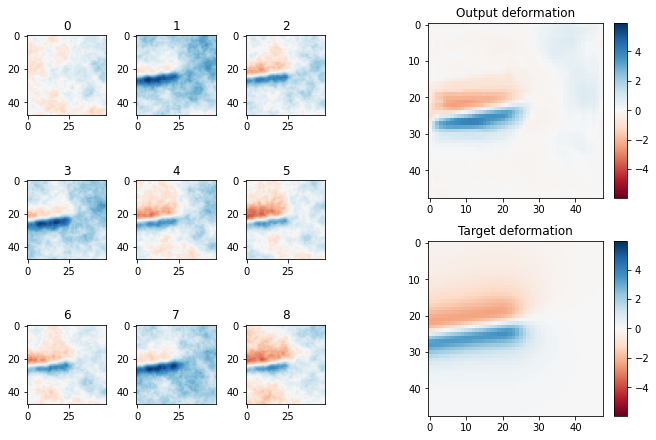

In [87]:
i = 25 # change this seed and rerun this cell to see different examples

x_img = X_test[i][1:]   # X_test is unscaled
targ_img = y_test[i].squeeze()    # y_test is unscaled
y_img = predictions[i].squeeze()   # predictions has been de-scaled
print("Max target deformation: ", targ_img.max())

plot_data_cust(x_img, targ_img, y_img)

Max target deformation:  3.0632365


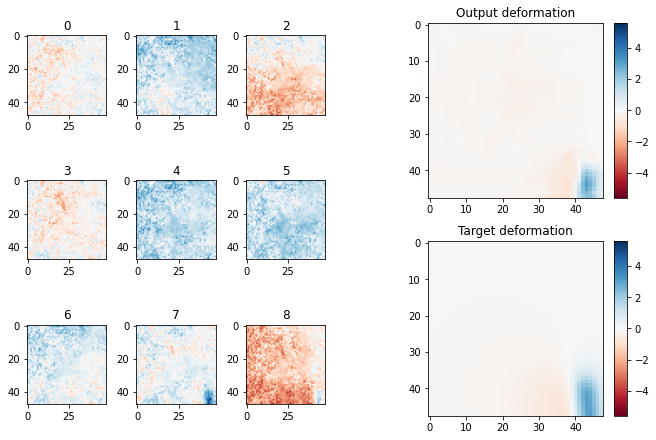

In [122]:
i = 20 # change this seed and rerun this cell to see different examples

x_img = X_test[i][1:]   # X_test is unscaled
targ_img = y_test[i].squeeze()    # y_test is unscaled
y_img = predictions[i].squeeze()   # predictions has been de-scaled
print("Max target deformation: ", targ_img.max())

plot_data_cust(x_img, targ_img, y_img)

#### Keras padding functions are lacking!!

In [117]:
# plt.figure(figsize=(8,8))
# plt.imshow(y_img[:18, -18:], cmap='RdBu')

#### Evaluation on Synthetic Data using SSIM

In [31]:
def avg_ssim(predictions, targets):
    """Take the SSIM for each prediction - target pair in the test set, and return the average
    across the entire test set"""
    ssims = list()
    for i in range(len(predictions)):
        pred_img = predictions[i][0, :, :, :]
        target_img = targets[i]
        ssims.append(tf.image.ssim(pred_img, target_img, 2, filter_size=8))
    return np.average(ssims)

In [32]:
# the paper appears to be using MSSIM not SSIM, but they are not taking the average anywhere
# that's something I'm doing to get a nice single metric to use to evaluate the different
# model runs I'm doing. 

def avg_mssim(predictions, targets):
    """For each prediction-target pair in the set, take 8x8 windows, calculate SSIM, average
    across the image, then average across the entire test set"""
    all_ssims = list()
    
    # reshape to needed sizes for patch making
    predictions = predictions[:, 0, :, :]
    
    # make patches
    filter_dims = (1,8,8,1)
    rates = (1,1,1,1)
    
    preds_patches = tf.image.extract_patches(predictions,
                                             sizes=filter_dims,
                                             strides=filter_dims,
                                             rates=(1,1,1,1),
                                             padding='VALID')

    preds_patches = np.array(preds_patches).reshape(preds_patches.shape[0], 36, 64)
    preds_patches = preds_patches.reshape(-1, 36, 8, 8)
    
    targs_patches = tf.image.extract_patches(targets,
                                             sizes=filter_dims,
                                             strides=filter_dims,
                                             rates=(1,1,1,1),
                                             padding='VALID')
    
    # reshape for needed sizes for SSIM
    targs_patches = np.array(targs_patches).reshape(targs_patches.shape[0], 36, 64)
    targs_patches = targs_patches.reshape(-1, 36, 8, 8)
    
    # run SSIM for patches
    mssims = list()
    for i in range(len(predictions)):
        local_ssims = tf.image.ssim(preds_patches[i], targs_patches[i], max_val=2, filter_size=3)
        mssims.append(np.average(local_ssims))
    
    return np.average(mssims)

In [88]:
avg_ssim(predictions_scaled, scaled_y_test)

0.36392003

In [89]:
avg_mssim(predictions_scaled, scaled_y_test)

0.34131208

#### Comparison of different training sets and models using SSIM
Not comparable to results in Notebook anne-1 since we changed normalization strategies.

| Avg Validation SSIM | Dataset/Run Notes | Saved model | 
| ---- | ---- | ---- |
|  |  |  | 

## Performance on Real Data

#### Load test data

In [107]:
test_name = "texas_test4"
texas_test = np.load(f"/data5/autoencoder/texas_dem/{test_name}.npy")
texas_test.shape

(37, 10, 210, 210)

In [108]:
indices = [9,18,27,36]
texas_test = texas_test[indices,..., None]
texas_test.shape

(4, 10, 210, 210, 1)

#### Run data through the normalizer

In [109]:
dem, timeseries = unstack_dem_timeseries(texas_test)
print(dem.shape, timeseries.shape)
dem_scaled = dem_scaler.transform(dem)
timeseries_scaled = timeseries_scaler.transform(timeseries)
print(dem_scaled.shape, timeseries_scaled.shape)
test_scaled = stack_dem_timeseries(dem_scaled, timeseries_scaled)
test_scaled.shape

(4, 1, 210, 210, 1) (4, 9, 210, 210, 1)
(4, 1, 210, 210, 1) (4, 9, 210, 210, 1)


(4, 10, 210, 210, 1)

#### Predict

In [110]:
texas_predictions_scaled = autoencoder.predict(test_scaled)
texas_predictions = timeseries_scaler.inverse_transform(texas_predictions_scaled)

#### Plot

In [111]:
def plot_data_output(X, output, n=9, vm=None, cmap="RdBu"):

    vm = vm or np.max(np.abs(X))
    # fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    fig = plt.figure(constrained_layout=True, figsize=(9, 6))
    gs0 = fig.add_gridspec(1, 2)

    gs_left = gs0[0].subgridspec(3, 3)
    gs_right = gs0[1].subgridspec(2, 1)
    # Input timesteps
    for a in range(3):
        for b in range(3):
            i = 3 * a + b
            ax = fig.add_subplot(gs_left[a, b])
            ax.imshow(X[i], cmap=cmap, vmin=-vm, vmax=vm)
            ax.set_title(f"{i}")

    # Right side: output, and target deformation
    ax = fig.add_subplot(gs_right[0, 0])
    axim = ax.imshow(output, cmap=cmap, vmin=-vm, vmax=vm)
    fig.colorbar(axim, ax=ax)
    ax.set_title("Output subsidence (cm)")

In [112]:
texas_predictions.shape

(4, 1, 210, 210, 1)

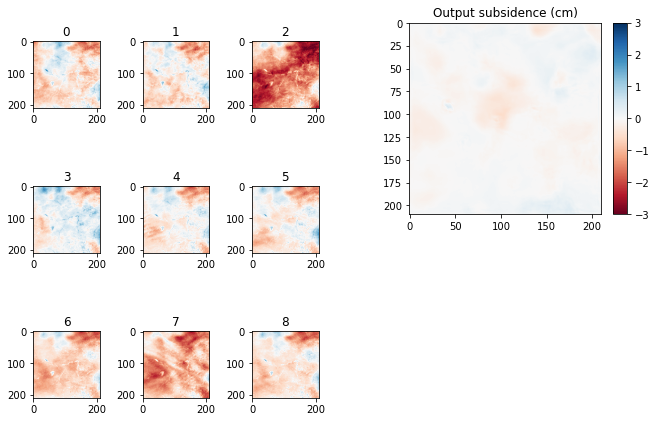

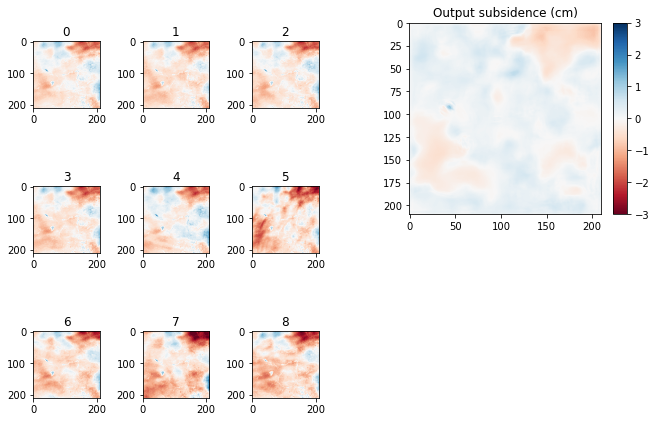

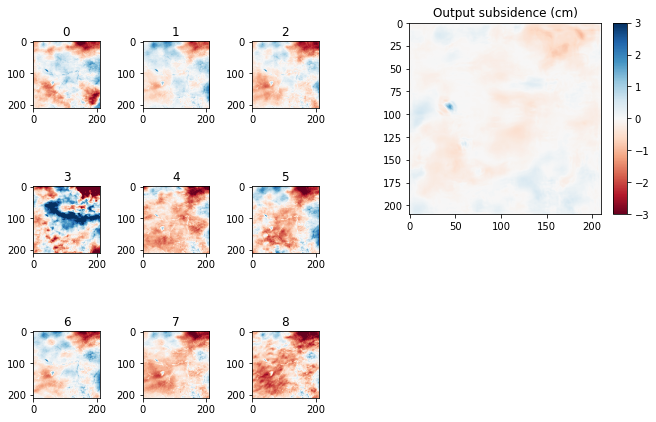

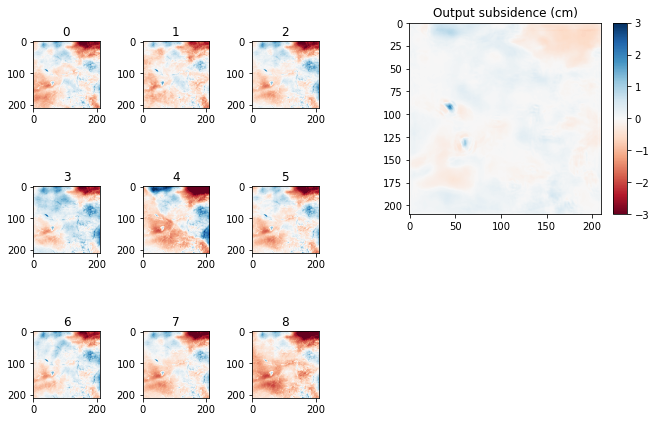

In [116]:
for i in range(len(texas_predictions)):
    plot_data_output(texas_test[i][1:].squeeze(), texas_predictions[i].squeeze(), vm=3)

#plot_data_output(texas_test[0][1:].squeeze(), texas_predictions[0].squeeze())

In [115]:
ds_file = f"/data5/autoencoder/texas_dem/{test_name}.nc"
save_predictions_as_tifs(texas_predictions.squeeze(), ds_file, indices)

## Differences with the paper's implementation

- Loss: they used mean absolute error, we used SSIM
- They used ~1M+ training examples, we have far fewer. Their graphs also showed higher training epochs (our performance leveled out faster). 
- Scott has a different noise generation process

## Notes and questions about the paper (Anne's)
- How does our amt of noise compare to the paper? (SNR seems like a weird metric here, given that the deformation signal does not appear in all 9 images. With their method of calculation, for the same size/shape/magnitude fault and same noise level, if the slip appears on the 2nd day of 9 vs. the 8th day of 9, the SNR is wildly different. It seems like it should be a little different, but maybe not that much?)
- Did they have deformation in every single training image? (Appears yes from example time series, plus they don't mention that not being the case). 
- In the review notes discussing the Turkish fault examination, they noted that they had false positives always at a 45 degree angle. Scott noted that the using threading in Python with randn results in the same seed being used across threads, which causes "duplicate" shapes -- this happened in his code and he fixed it, and it could possibly explain their "45 degree artifacts" as well.  
- They say in their Turkish example that they've detected extra slippage of 1mm - 2mm, but they have false positive artifacts of ~6mm, which seems like a big disconnect. I think this points to maybe the utility of ML to detect areas of interest when given a lot of images, as opposed to more precisely determining slippage magnitude and location than previous, less automated techniques. 

## Model versions
- anne_test_5 = SSIM loss and no noisy data: `load_all_data(data_dir + "simulated_stack0*.h5", data_dir + "elevation_looked.dem", normalize=False, no_noise=True)`
- anne_test_6 = SSIM loss and noisy data. This version looks quite good: `load_all_data(data_dir + "simulated_stack0*.h5", data_dir + "elevation_looked.dem", normalize=False)`
- anne_test_7 = SSIM loss, noisy data, artifacts from 1st day added: `load_all_data(data_dir + "simulated_stack_day1*.h5", data_dir + "elevation_looked.dem", normalize=False)`

agh I didn't save the scalers. Good luck using this info.